In [46]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import torch
from matplotlib import pyplot as plt 
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
import os
import json
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import pandas as pd
from time import time

# 手动实现前馈神经网络解决上述回归、二分类、多分类任务

# 回归手动实现

In [153]:
# 设置随机种子保证可复现性
np.random.seed(42)
torch.manual_seed(42)
# 参数配置
n_samples = 10000       # 总样本量
p = 500                 # 特征维度
train_size = 7000       # 训练集大小
test_size = 3000        # 测试集大小
true_bias = 0.028       # 真实偏置项
true_weights = 0.0056   # 统一权重系数（所有特征同等重要）

# 生成数据
def generate_data(n_samples, p):
    # 生成特征矩阵 (n_samples, p)
    X = np.random.randn(n_samples, p)
    
    # 生成真实权重 (p, 1) - 所有特征权重相同
    w = np.full((p, 1), true_weights)
    
    # 生成噪声项 ϵ ~ N(0, 0.1)
    epsilon = np.random.normal(0, 0.2, size=(n_samples, 1))
    
    X = (X - X.mean(axis=0)) / X.std(axis=0)  # 先标准化
    
    # 计算标签 y = 0.028 + 0.0056*∑x_i + ϵ
    y = true_bias + X.dot(w) + epsilon
    
    
    return X, y.squeeze()  # 将y从(n_samples,1)压缩为(n_samples,)

# 生成完整数据集
X, y = generate_data(n_samples, p)

# 数据标准化（重要！高维数据必须标准化）
# 不同特征的量纲和取值范围差异大（如年龄 0-100，收入 0-1,000,000），导致：
#     权重大的特征可能仅仅因为数值大而主导模型。
#     梯度下降收敛缓慢（需反复调整学习率）。
# 假设有两个特征：
#     x1: 年龄（范围 0-100）
#     x2: 收入（范围 0-1,000,000）
# 若直接计算点积 y=w1*x1+w2*x2：
#     收入 x2的微小变化会完全掩盖年龄 x1的影响。
#     梯度下降时，w2的更新步长需要极小的学习率，而 w1则需要较大的学习率，难以平衡。
# X = (X - X.mean(axis=0)) / X.std(axis=0)

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, random_state=42
)

# 转换为PyTorch张量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 验证生成数据的正确性
def verify_data(X, y, n_check=3):
    for i in range(n_check):
        manual_y = true_bias + 0.0056 * X[i].sum()
        print(f"样本{i}: 计算值={manual_y:.4f}, 生成值={y[i]:.4f}, 差值={abs(manual_y - y[i]):.4f}")

print("=== 训练集验证 ===")
verify_data(X_train, y_train)
print("\n=== 测试集验证 ===")
verify_data(X_test, y_test)

# 输出数据形状
print("\n=== 数据形状 ===")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# 检查权重一致性
print(f"\n真实权重: 偏置={true_bias}, 特征权重={true_weights} (所有特征相同)")

=== 训练集验证 ===
样本0: 计算值=0.1533, 生成值=0.3005, 差值=0.1473
样本1: 计算值=0.0437, 生成值=-0.0745, 差值=0.1181
样本2: 计算值=-0.1449, 生成值=0.0553, 差值=0.2003

=== 测试集验证 ===
样本0: 计算值=0.0827, 生成值=-0.0233, 差值=0.1059
样本1: 计算值=0.0195, 生成值=0.2838, 差值=0.2643
样本2: 计算值=0.0179, 生成值=-0.1031, 差值=0.1210

=== 数据形状 ===
X_train: torch.Size([7000, 500]), y_train: torch.Size([7000])
X_test: torch.Size([3000, 500]), y_test: torch.Size([3000])

真实权重: 偏置=0.028, 特征权重=0.0056 (所有特征相同)


In [156]:
seed = 17
train_ds_logits = TensorDataset(X_train, y_train)
train_ds_logits, val_ds_logits = random_split(train_ds_logits, [6000, 1000], torch.Generator().manual_seed(seed))
test_ds_logits = TensorDataset(X_test, y_test)

In [157]:
train_dl_logits = DataLoader(train_ds_logits, batch_size=32, shuffle=True)
val_dl_logits = DataLoader(val_ds_logits, batch_size=32, shuffle=True)
test_dl_logits = DataLoader(test_ds_logits, batch_size=32, shuffle=True)

In [158]:
# 梯度下降
def SGD(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [159]:
def relu(x):
    return torch.max(input=x, other=torch.tensor(0.0))

He初始化$ W \thicksim N(0, \sqrt{\frac{2}{n}}) $

In [160]:
class ManualNeuralNetwork:
    def __init__(self, layer_dims, activation='relu'):
        self.layer_dims = layer_dims
        self.activation = activation
        self.weights = []
        self.bias = []
        for i in range(len(layer_dims) - 1):
            # He初始化
            w = torch.tensor(np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2 / layer_dims[i]),requires_grad=True, dtype=torch.float32)
            b = torch.tensor(np.zeros((1, layer_dims[i+1])), requires_grad=True, dtype=torch.float32)
            self.weights.append(w)
            self.bias.append(b) 
          
    
    def forward(self, x):
        self.outputs = x
        for i in range(len(self.weights) - 1):
            self.outputs = torch.matmul(self.outputs, self.weights[i]) + self.bias[i]
            if self.activation == 'relu':
                self.outputs = relu(self.outputs)
        self.outputs = torch.matmul(self.outputs, self.weights[len(self.weights) - 1]) + self.bias[len(self.weights) - 1]
        return  self.outputs
    
    
    def sgd(self, lr, batch_size):
        SGD(self.weights, lr, batch_size)
        SGD(self.bias, lr, batch_size)
        
    def grad_zero(self):
        for i in range(len(self.weights)):
            self.weights[i].grad.zero_()
            self.bias[i].grad.zero_()
            
            

In [161]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [162]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [163]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    mae = torch.tensor(0.0)
    for datas, labels in dataloader:
        # 前向计算
        logits = model.forward(datas)              # 验证集预测
        loss = loss_fct(logits.view(-1), labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        
        # pred_list.extend(logits.detach().numpy().tolist()) # 将验证集预测结果加入列表
        # label_list.extend(labels.detach().numpy().tolist())# 将验证集真实标签加入列表
        mae += torch.mean(torch.abs(logits - labels))
    # acc = accuracy_score(np.round(label_list * 100).astype(int), np.round(pred_list*100).astype(int)) # 计算验证集准确率
    return np.mean(loss_list), mae / len(dataloader) # 返回验证集损失均值和准确率


In [164]:
# 训练
def training_manual_logist(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train":[],
        "val":[]
    }
    global_step = 0
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                logits=model.forward(datas)
                loss=loss_fct(logits.view(-1), labels)
                loss.backward()
                model.sgd(0.01, 32)
                model.grad_zero()
                # 方法2：手动计算
                mae = torch.mean(torch.abs(logits - labels))
                record_dict["train"].append({
                    "loss":loss.detach().numpy(), "mae":mae.detach().numpy(), "step":global_step
                })
                
                if global_step % eval_step == 0:
                    val_loss, val_mae = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss":val_loss, "mae":val_mae, "step":global_step
                    })
                    
                    if early_stop_callback is not None:
                        early_stop_callback(-val_mae)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
    
    return record_dict

In [167]:
layer_dims = [500, 256, 128, 1]
epoch = 30
model_manual_logits = ManualNeuralNetwork(layer_dims)
loss_fct_manual_logits = nn.MSELoss()
early_stop_callback = EarlyStopCallback()
record_manual_logits = training_manual_logist(model_manual_logits, train_dl_logits, val_dl_logits, epoch, loss_fct_manual_logits, early_stop_callback)

  0%|          | 0/5640 [00:00<?, ?it/s]

Early stop at epoch 26 / global_step 4900


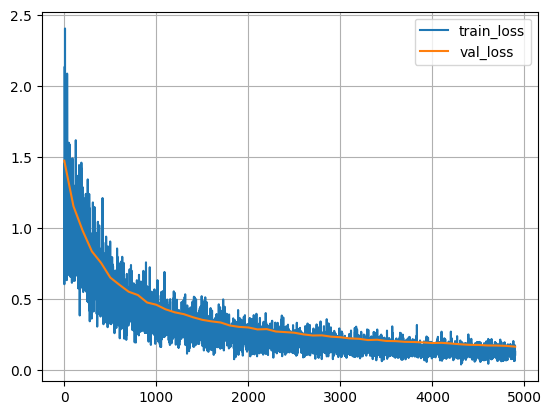

In [177]:
plt.plot([i["step"] for i in record_manual_logits["train"]], [i["loss"] for i in record_manual_logits["train"]], label="train_loss")
plt.plot([i["step"] for i in record_manual_logits["val"]], [i["loss"] for i in record_manual_logits["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.show()

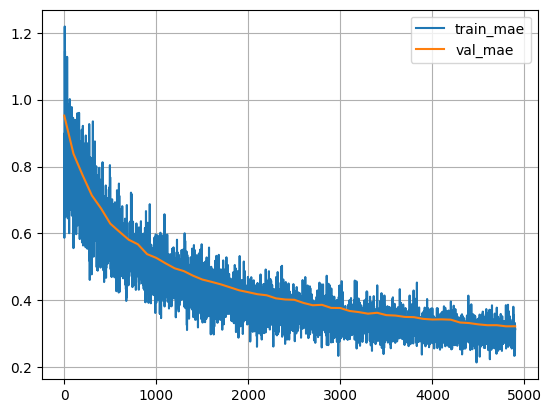

In [174]:
plt.plot([i["step"] for i in record_manual_logits["train"]], [i["mae"] for i in record_manual_logits["train"]], label="train_mae")
plt.plot([i["step"] for i in record_manual_logits["val"]], [i["mae"] for i in record_manual_logits["val"]], label="val_mae")
plt.grid()
plt.legend()
plt.show()

In [175]:
loss, mae= evaluating(model_manual_logits, test_dl_logits, loss_fct_manual_logits)
print(f"loss:     {loss:.4f}\nmae: {mae:.4f}")

loss:     0.1627
mae: 0.3302


# 回归使用torch.nn

In [178]:
class NnNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(500, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.init_weight()
    
    
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    
    def forward(self, x):
        return self.net(x)

In [179]:
@torch.no_grad()
def evaluating4(model, dataloader, loss_fct):
    loss_list = []
    mae = torch.tensor(0.0)
    for datas, labels in dataloader:
        # 前向计算
        logits = model(datas)              # 验证集预测
        loss = loss_fct(logits.view(-1), labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        
        mae += torch.mean(torch.abs(logits - labels))
    return np.mean(loss_list), mae / len(dataloader) # 返回验证集损失均值和准确率


In [180]:
# 训练
def training_nn_logist(
    model, 
    train_loader, 
    val_loader, 
    optimizer,
    epoch, 
    loss_fct, 
    early_stop_callback=None,
    eval_step=100,
    ):
    record_dict = {
        "train":[],
        "val":[]
    }
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                optimizer.zero_grad()
                logits=model(datas)
                loss=loss_fct(logits.view(-1), labels)
                loss.backward()
                optimizer.step()
                # 方法2：手动计算
                mae = torch.mean(torch.abs(logits - labels))
                record_dict["train"].append({
                    "loss":loss.detach().numpy(), "mae":mae.detach().numpy(), "step":global_step
                })
                
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_mae = evaluating4(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss":val_loss, "mae":val_mae, "step":global_step
                    })
                    model.train()
                    
                    if early_stop_callback is not None:
                        early_stop_callback(-val_mae)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
    
    return record_dict

In [181]:
epoch = 30
model_nn_logist = NnNeuralNetwork()
loss_fct_nn_logist = nn.MSELoss()
early_stop_callback_nn_logist = EarlyStopCallback()
# 初始化Adam优化器
optimizer_nn_logist = torch.optim.Adam(model_nn_logist.parameters(), lr=0.001, weight_decay=1e-4)
record = training_nn_logist(model_nn_logist, train_dl_logits, val_dl_logits, optimizer_nn_logist, epoch, loss_fct_nn_logist, early_stop_callback_nn_logist)

  0%|          | 0/5640 [00:00<?, ?it/s]

Early stop at epoch 4 / global_step 800


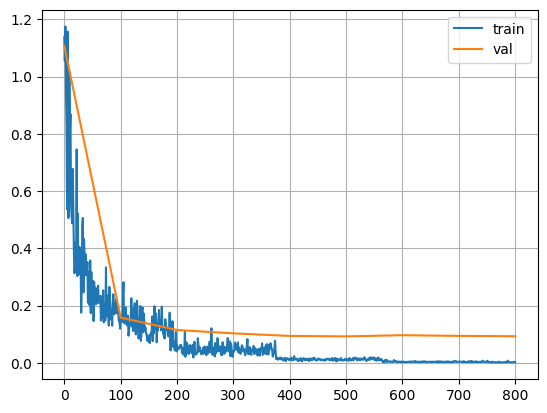

In [182]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

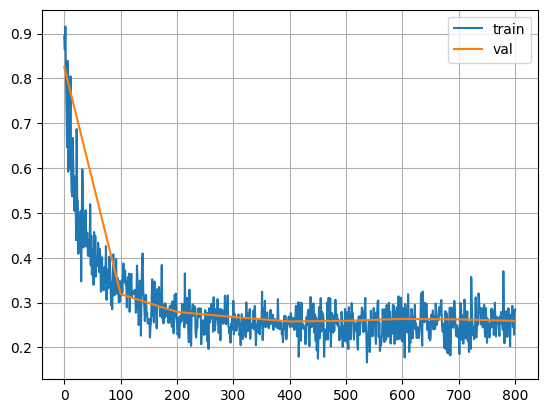

In [183]:
plt.plot([i["step"] for i in record["train"]], [i["mae"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["mae"] for i in record["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

In [184]:
model_nn_logist.eval()
loss, mae= evaluating4(model_nn_logist, test_dl_logits, loss_fct_nn_logist)
print(f"loss:     {loss:.4f}\nmae: {mae:.4f}")

loss:     0.0957
mae: 0.2694


# 二分类

In [197]:
# 设置随机种子保证可复现性
np.random.seed(42)

# 参数配置
n_samples = 10000       # 每个数据集的样本量
p = 200                # 特征维度
train_size = 7000      # 训练集大小
test_size = 3000       # 测试集大小
mean_diff = 1.0        # 两个数据集均值的差异幅度
common_var = 1.0       # 共同的方差

# 生成第一个数据集（标签0）
X0 = np.random.normal(loc=-mean_diff/2, scale=np.sqrt(common_var), size=(n_samples, p))
y0 = np.zeros(n_samples)  # 标签全为0

# 生成第二个数据集（标签1）
X1 = np.random.normal(loc=mean_diff/2, scale=np.sqrt(common_var), size=(n_samples, p))
y1 = np.ones(n_samples)   # 标签全为1

# 合并两个数据集
X = np.vstack((X0, X1))
y = np.hstack((y0, y1))
print(X.shape)
# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size*2, test_size=test_size*2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=10000, test_size=4000, random_state=42, stratify=y_train)

(20000, 200)


In [198]:
# 将np转为tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_val = torch.from_numpy(X_val)
y_val = torch.from_numpy(y_val)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)
train_ds_binary = TensorDataset(X_train, y_train)
val_ds_binary = TensorDataset(X_val, y_val)
test_ds_binary = TensorDataset(X_test, y_test)

In [199]:
train_dl_binary = DataLoader(train_ds_binary, batch_size=32, shuffle=True)
val_dl_binary = DataLoader(val_ds_binary, batch_size=32, shuffle=True)
test_dl_binary = DataLoader(test_ds_binary, batch_size=32, shuffle=True)

In [200]:
class ManualBinaryNetwork:        
    def __init__(self, layer_dims, activation='relu'):
        self.layer_dims = layer_dims
        self.activation = activation
        self.weights = []
        self.bias = []
        for i in range(len(layer_dims) - 1):
            # He初始化
            w = torch.tensor(np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2 / layer_dims[i]),requires_grad=True)
            b = torch.tensor(np.zeros((1, layer_dims[i+1])), requires_grad=True)
            self.weights.append(w)
            self.bias.append(b) 
              
        
    def forward(self, x):
        self.outputs = x
        for i in range(len(self.weights) - 1):
            self.outputs = torch.matmul(self.outputs, self.weights[i]) + self.bias[i]
            if self.activation == 'relu':
                self.outputs = relu(self.outputs)
        self.outputs = torch.matmul(self.outputs, self.weights[len(self.weights) - 1]) + self.bias[len(self.weights) - 1]
        return  self.outputs
    
    
    def sgd(self, lr, batch_size):
        SGD(self.weights, lr, batch_size)
        SGD(self.bias, lr, batch_size)
        
        
    def grad_zero(self):
        for i in range(len(self.weights)):
            self.weights[i].grad.zero_()
            self.bias[i].grad.zero_()

In [201]:
@torch.no_grad()
def evaluating2(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        # 前向计算
        logits = model.forward(datas)              # 验证集预测
        loss = loss_fct(logits.view(-1), labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        logits = torch.sigmoid(logits)
        preds = (logits >= 0.5)
        pred_list.extend(preds.detach().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.detach().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(label_list, pred_list) # 计算验证集准确率
    return np.mean(loss_list), acc

In [202]:
def training_manual_binary( model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    early_stop_callback=None,
    eval_step=200,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                logits = model.forward(datas)
                loss = loss_fct(logits.view(-1), labels)
                loss.backward()
                model.sgd(0.01, 32)
                model.grad_zero()
                logits = torch.sigmoid(logits)
                preds = (logits >= 0.5)
            
                acc = accuracy_score(labels.detach().numpy(), preds.detach().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                 # evaluating
                if global_step % eval_step == 0:
                    val_loss, val_acc = evaluating2(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [203]:
epoch=30
layer_dims = [200, 128, 64, 32, 16, 1]
model_manual_binary = ManualBinaryNetwork(layer_dims)
early_stop_callback_manual_binary = EarlyStopCallback()
loss_fct_manual_binary = nn.BCEWithLogitsLoss()
record_manual_binary = training_manual_binary(model_manual_binary,train_dl_binary,val_dl_binary,epoch,loss_fct_manual_binary,early_stop_callback_manual_binary)

  0%|          | 0/9390 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 1800


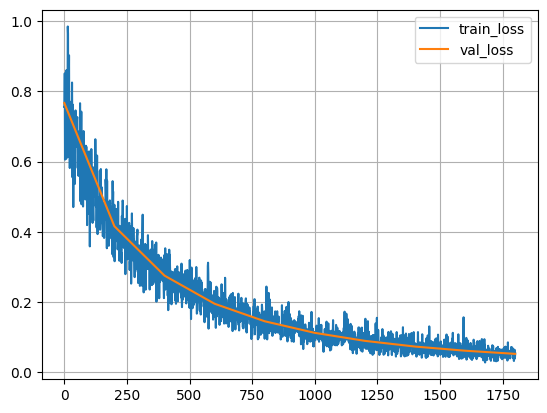

In [207]:
plt.plot([i["step"] for i in record_manual_binary["train"]], [i["loss"] for i in record_manual_binary["train"]], label="train_loss")
plt.plot([i["step"] for i in record_manual_binary["val"]], [i["loss"] for i in record_manual_binary["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.show()

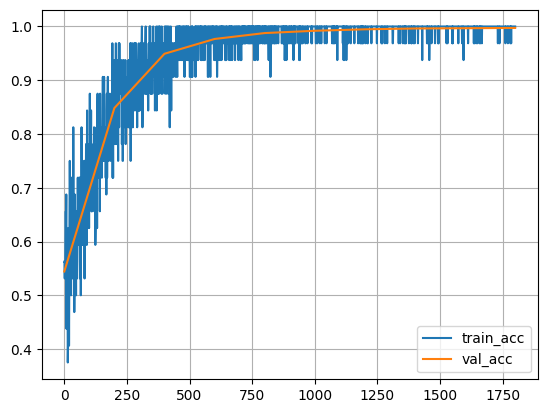

In [208]:
plt.plot([i["step"] for i in record_manual_binary["train"]], [i["acc"] for i in record_manual_binary["train"]], label="train_acc")
plt.plot([i["step"] for i in record_manual_binary["val"]], [i["acc"] for i in record_manual_binary["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.show()

In [206]:
loss, acc= evaluating2(model_manual_binary, test_dl_binary, loss_fct_manual_binary)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.0508
acc: 0.9977


# torch.nn 二分类

In [209]:
class NnBinaryNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # 200, 128, 64, 32, 16, 1
            nn.Linear(200, 128, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(128, 64, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(64, 32, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(32, 16, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(16, 1, dtype=torch.float64)
        )
        self.init_weight()

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


In [210]:
@torch.no_grad()
def evaluating5(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        # 前向计算
        logits = model.forward(datas)              # 验证集预测
        loss = loss_fct(logits.view(-1), labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        logits = torch.sigmoid(logits)
        preds = (logits >= 0.5)
        pred_list.extend(preds.detach().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.detach().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(label_list, pred_list) # 计算验证集准确率
    return np.mean(loss_list), acc

In [211]:
# 训练
def training_nn_binary(
        model,
        train_loader,
        val_loader,
        optimizer,
        epoch,
        loss_fct,
        early_stop_callback=None,
        eval_step=200,
):
    record_dict = {
        "train": [],
        "val": []
    }
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                optimizer.zero_grad()
                logits = model(datas)
                loss = loss_fct(logits.view(-1), labels)
                loss.backward()
                optimizer.step()
                logits = torch.sigmoid(logits)
                preds = (logits >= 0.5)
                acc = accuracy_score(labels.detach().numpy(), preds.detach().numpy())
                record_dict["train"].append({
                    "loss": loss.detach().numpy(), "acc": acc, "step": global_step
                })

                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating5(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


In [212]:
epoch = 30
model_nn_binary = NnBinaryNetwork()
loss_fct_nn_binary = nn.BCEWithLogitsLoss()
early_stop_callback_nn_binary = EarlyStopCallback()
# 初始化Adam优化器
optimizer_nn_binary = torch.optim.Adam(model_nn_binary.parameters(), lr=0.001, weight_decay=1e-4)
record_nn_binary = training_nn_binary(model_nn_binary, train_dl_binary, val_dl_binary, optimizer_nn_binary, epoch, loss_fct_nn_binary, early_stop_callback_nn_binary)

  0%|          | 0/9390 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200


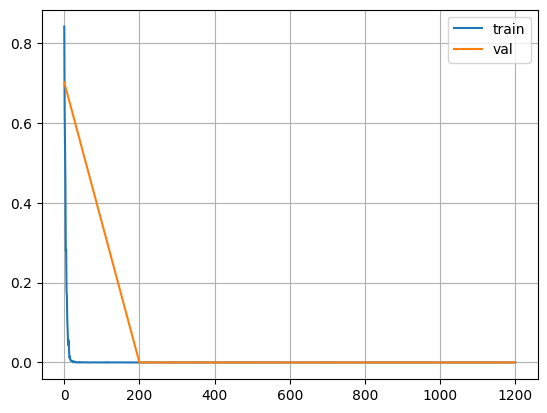

In [214]:
plt.plot([i["step"] for i in record_nn_binary["train"]], [i["loss"] for i in record_nn_binary["train"]], label="train")
plt.plot([i["step"] for i in record_nn_binary["val"]], [i["loss"] for i in record_nn_binary["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

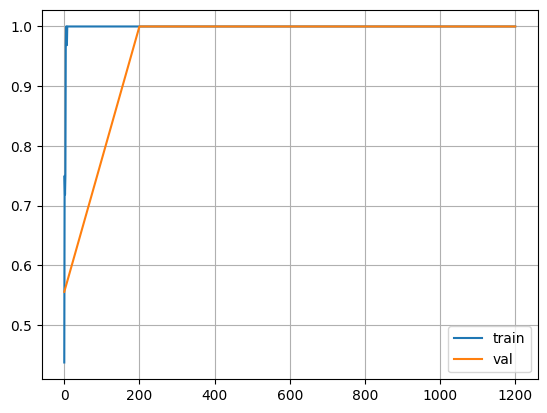

In [215]:
plt.plot([i["step"] for i in record_nn_binary["train"]], [i["acc"] for i in record_nn_binary["train"]], label="train")
plt.plot([i["step"] for i in record_nn_binary["val"]], [i["acc"] for i in record_nn_binary["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

In [216]:
model_nn_binary.eval()
loss, acc = evaluating5(model_nn_binary, test_dl_binary, loss_fct_nn_binary)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.0000
acc: 1.0000


# 多分类

# 手动实现多分类

In [217]:
train_transform = transforms.Compose([
    transforms.RandomRotation(5),                      # 减小旋转角度
    transforms.RandomAffine(0, translate=(0.05, 0.05)),  # 减小平移范围
    transforms.RandomCrop(28, padding=4, padding_mode='edge'),  # 安全裁剪
    transforms.ColorJitter(brightness=0.05, contrast=0.05),  # 降低调整强度
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.005),  # 提前加噪声
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # 在Tensor上操作
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])
train_ds = torchvision.datasets.MNIST("./Datasets/MNIST", train=True, transform=train_transform, download=True)
test_ds = torchvision.datasets.MNIST("./Datasets/MNIST", train=False, transform=test_transform, download=True)

In [218]:
data = train_ds.data.float()

# 计算全局均值和标准差
mean = data.mean()
std = data.std()
print(mean)
print(std)

tensor(33.3184)
tensor(78.5675)


In [226]:
print(len(test_ds))

10000


In [220]:
seed = 17
train_ds_multi, val_ds_multi = random_split(train_ds, [55000, 5000],  torch.Generator().manual_seed(seed))

In [221]:
train_dl_multi = DataLoader(train_ds_multi, 32, shuffle=True)
val_dl_multi = DataLoader(val_ds_multi, 32, shuffle=True)
test_dl_multi = DataLoader(test_ds, 32, shuffle=True)

In [222]:
class ManualMultiNetwork:        
    def __init__(self, layer_dims, activation='relu'):
        self.layer_dims = layer_dims
        self.activation = activation
        self.weights = []
        self.bias = []
        for i in range(len(layer_dims) - 1):
            # He初始化
            w = torch.tensor(np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2 / layer_dims[i]),requires_grad=True, dtype=torch.float32)
            b = torch.tensor(np.zeros((1, layer_dims[i+1])), requires_grad=True, dtype=torch.float32)
            self.weights.append(w)
            self.bias.append(b) 
              
        
    def forward(self, x):
        self.outputs = x
        for i in range(len(self.weights) - 1):
            self.outputs = torch.matmul(self.outputs, self.weights[i]) + self.bias[i]
            if self.activation == 'relu':
                self.outputs = relu(self.outputs)
        self.outputs = torch.matmul(self.outputs, self.weights[len(self.weights) - 1]) + self.bias[len(self.weights) - 1]
        return  self.outputs
    
    
    def sgd(self, lr, batch_size):
        SGD(self.weights, lr, batch_size)
        SGD(self.bias, lr, batch_size)
        
        
    def grad_zero(self):
        for i in range(len(self.weights)):
            self.weights[i].grad.zero_()
            self.bias[i].grad.zero_()

In [223]:
@torch.no_grad()
def evaluating3(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        # 前向计算
        datas = datas.view(datas.size(0), -1)
        logits = model.forward(datas)              # 验证集预测
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        preds = logits.argmax(axis=-1)
        pred_list.extend(preds.detach().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.detach().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(label_list, pred_list) # 计算验证集准确率
    return np.mean(loss_list), acc

In [224]:
def training( model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                datas = datas.view(datas.size(0), -1)
                logits = model.forward(datas)
                loss = loss_fct(logits, labels)
                loss.backward()
                model.sgd(0.01, 32)
                model.grad_zero()
                preds = logits.argmax(-1)
            
                acc = accuracy_score(labels.detach().numpy(), preds.detach().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                 # evaluating
                if global_step % eval_step == 0:
                    val_loss, val_acc = evaluating3(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [225]:
epoch = 30
layer_dims = [784, 256, 128, 64, 32, 10]
model_manual_multi = ManualMultiNetwork(layer_dims)
early_stop_callback_manual_multi = EarlyStopCallback()
loss_fct_manual_multi = nn.CrossEntropyLoss()
record_manual_multi = training(model_manual_multi, train_dl_multi, val_dl_multi, epoch, loss_fct_manual_multi, early_stop_callback_manual_multi)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 18 / global_step 31500


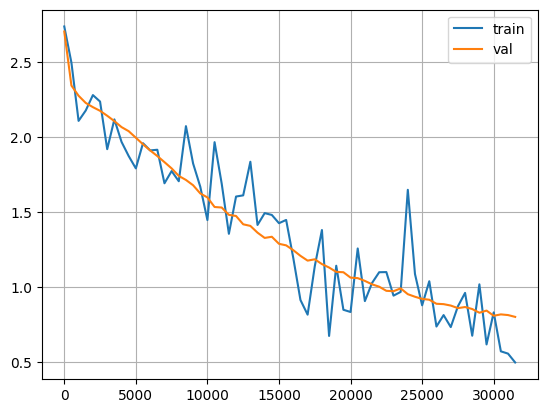

In [227]:
loss = [i["loss"] for i in record_manual_multi["train"]]
step = [i["step"] for i in record_manual_multi["train"]]
plt.plot(step[::500], loss[::500], label="train")
plt.plot([i["step"] for i in record_manual_multi["val"]], [i["loss"] for i in record_manual_multi["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

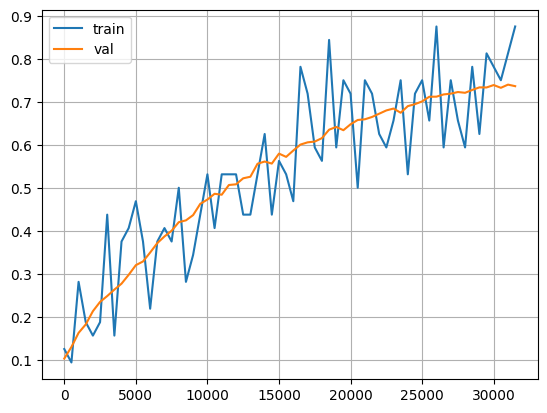

In [228]:
acc = [i["acc"] for i in record_manual_multi["train"]]
step = [i["step"] for i in record_manual_multi["train"]]
plt.plot(step[::500], acc[::500], label="train")
plt.plot([i["step"] for i in record_manual_multi["val"]], [i["acc"] for i in record_manual_multi["val"]], label="val")
plt.grid()
plt.legend()
plt.show()

In [231]:
loss, acc= evaluating3(model_manual_multi, test_dl_multi, loss_fct_manual_multi)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.4922
acc: 0.8540


# torch.nn 多分类

In [232]:
class NnMultiNetwork(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        # 定义可选的激活函数
        activation_fns = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "leakyrelu": nn.LeakyReLU(negative_slope=0.1),
            "gelu": nn.GELU(),
            "sigmoid": nn.Sigmoid()
        }
        assert activation in activation_fns, f"Unsupported activation: {activation}"
        
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(256, 128),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(128, 64),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(64, 32),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(32, 10)
        )
        self.init_weight()
        
        
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

In [233]:
@torch.no_grad()
def evaluating6(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        # 前向计算
        logits = model.forward(datas)              # 验证集预测
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        preds = logits.argmax(axis=-1)
        pred_list.extend(preds.detach().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.detach().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(label_list, pred_list) # 计算验证集准确率
    return np.mean(loss_list), acc

In [234]:
# 训练
def training_nn_multi(
        model,
        train_loader,
        val_loader,
        optimizer,
        epoch,
        loss_fct,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                optimizer.zero_grad()
                logits = model(datas)
                loss = loss_fct(logits, labels)
                loss.backward()
                optimizer.step()
                preds = logits.argmax(-1)
                acc = accuracy_score(labels.detach().numpy(), preds.detach().numpy())
                record_dict["train"].append({
                    "loss": loss.detach().numpy(), "acc": acc, "step": global_step
                })

                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating6(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


In [235]:
epoch = 30
model_nn_multi = NnMultiNetwork()
loss_fct_nn_multi = nn.CrossEntropyLoss()
early_stop_callback_nn_multi = EarlyStopCallback()
# 初始化Adam优化器
optimizer_nn_multi = torch.optim.Adam(model_nn_multi.parameters(), lr=0.0001, weight_decay=1e-4)
record_nn_multi = training_nn_multi(model_nn_multi, train_dl_multi, val_dl_multi, optimizer_nn_multi, epoch, loss_fct_nn_multi, early_stop_callback_nn_multi)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 6 / global_step 11000


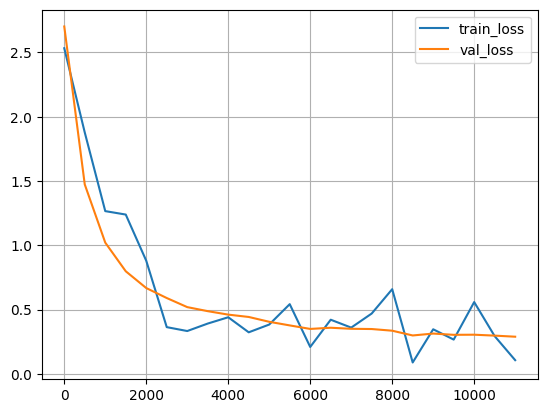

In [242]:
step=[i["step"] for i in record_nn_multi["train"]]
loss=[i["loss"] for i in record_nn_multi["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
plt.plot([i["step"] for i in record_nn_multi["val"]], [i["loss"] for i in record_nn_multi["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.show()

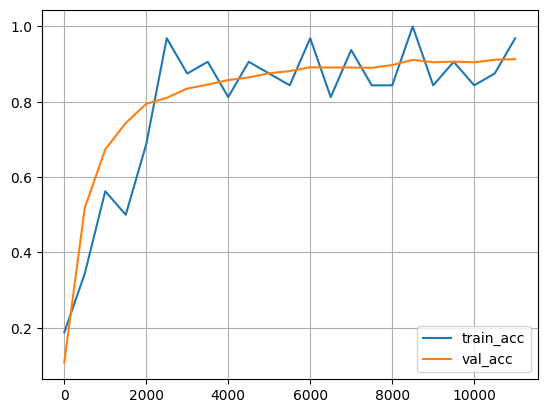

In [243]:
step=[i["step"] for i in record_nn_multi["train"]]
acc=[i["acc"] for i in record_nn_multi["train"]]
plt.plot(step[::500], acc[::500], label="train_acc")
plt.plot([i["step"] for i in record_nn_multi["val"]], [i["acc"] for i in record_nn_multi["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.show()

In [244]:
model_nn_multi.eval()

loss, acc= evaluating6(model_nn_multi, test_dl_multi, loss_fct_nn_multi)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.1618
acc: 0.9526


# 多分类任务使用三种不同的激活函数，上面使用的是Relu

# 激活函数为sigmoid

In [246]:
epoch = 30
model_sigmoid = NnMultiNetwork("sigmoid")
loss_fct_sigmoid = nn.CrossEntropyLoss()
early_stop_callback = EarlyStopCallback()
# 初始化Adam优化器
optimizer_sigmoid = torch.optim.Adam(model_sigmoid.parameters(), lr=0.001, weight_decay=1e-4)
record_sigmoid = training_nn_multi(model_sigmoid, train_dl_multi, val_dl_multi, optimizer_sigmoid, epoch, loss_fct_sigmoid, early_stop_callback)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 6500


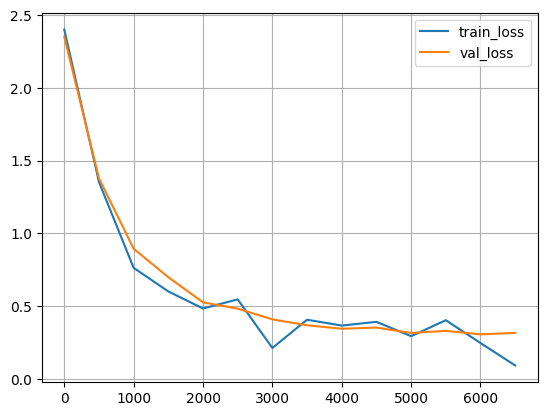

In [251]:
step = [i["step"] for i in record_sigmoid["train"]]
loss = [i["loss"] for i in record_sigmoid["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
plt.plot([i["step"] for i in record_sigmoid["val"]], [i["loss"] for i in record_sigmoid["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.show()

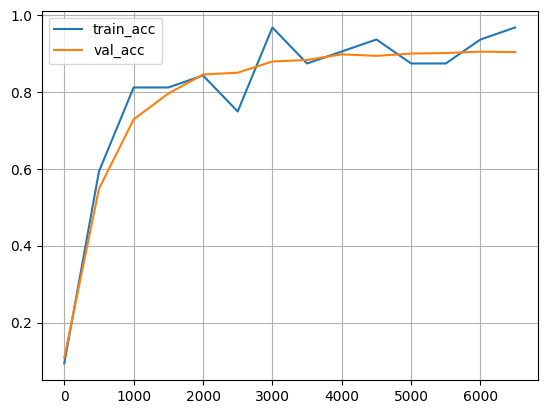

In [253]:
step=[i["step"] for i in record_sigmoid["train"]]
acc=[i["acc"] for i in record_sigmoid["train"]]
plt.plot(step[::500], acc[::500], label="train_acc")
plt.plot([i["step"] for i in record_sigmoid["val"]], [i["acc"] for i in record_sigmoid["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.show()

In [249]:
model_sigmoid.eval()
loss, acc= evaluating6(model_sigmoid, test_dl_multi, loss_fct_sigmoid)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.1757
acc: 0.9466


# 激活函数为tanh

In [255]:
model_tanh = NnMultiNetwork("tanh")
loss_fct_tanh = nn.CrossEntropyLoss()
early_stop_callback_tanh = EarlyStopCallback()
# 初始化Adam优化器
optimizer_tanh = torch.optim.Adam(model_tanh.parameters(), lr=0.0001, weight_decay=1e-4)
record_tanh = training_nn_multi(model_tanh, train_dl_multi, val_dl_multi, optimizer_tanh, epoch, loss_fct_tanh, early_stop_callback_tanh)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 6 / global_step 10500


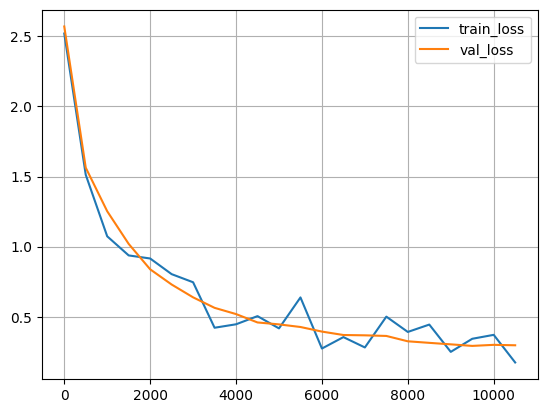

In [256]:
step = [i["step"] for i in record_tanh["train"]]
loss = [i["loss"] for i in record_tanh["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
plt.plot([i["step"] for i in record_tanh["val"]], [i["loss"] for i in record_tanh["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.show()

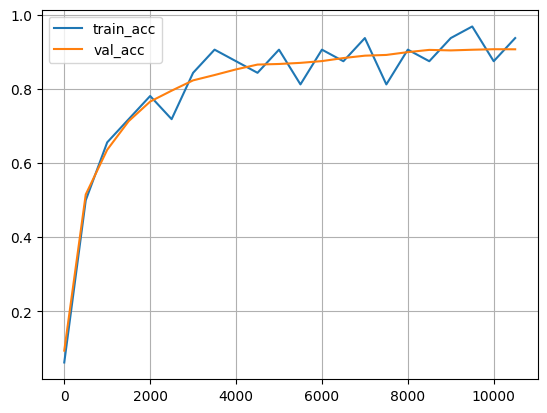

In [257]:
step = [i["step"] for i in record_tanh["train"]]
acc = [i["acc"] for i in record_tanh["train"]]

# 绘图
plt.plot(step[::500], acc[::500], label="train_acc")
# plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_tanh["val"]], [i["acc"] for i in record_tanh["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.show()

In [260]:
model_tanh.eval()
loss, acc= evaluating6(model_tanh, test_dl_multi, loss_fct_tanh)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.1746
acc: 0.9475


# 使用不同的层数和单元个数

In [261]:
class NnMultiNetwork2(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        # 定义可选的激活函数
        activation_fns = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "leakyrelu": nn.LeakyReLU(negative_slope=0.1),
            "gelu": nn.GELU(),
            "sigmoid": nn.Sigmoid()
        }
        assert activation in activation_fns, f"Unsupported activation: {activation}"
        
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 300),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(300, 100),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(100, 30),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(30, 10)
        )
        self.init_weight()
        
        
    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

In [262]:
epoch = 30
model_nn_multi2 = NnMultiNetwork2()
loss_fct_nn_multi2 = nn.CrossEntropyLoss()
early_stop_callback_nn_multi2 = EarlyStopCallback()
# 初始化Adam优化器
optimizer_nn_multi2 = torch.optim.Adam(model_nn_multi2.parameters(), lr=0.001, weight_decay=1e-4)
record_nn_multi2 = training_nn_multi(model_nn_multi2, train_dl_multi, val_dl_multi, optimizer_nn_multi2, epoch, loss_fct_nn_multi2, early_stop_callback_nn_multi2)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 4 / global_step 7500


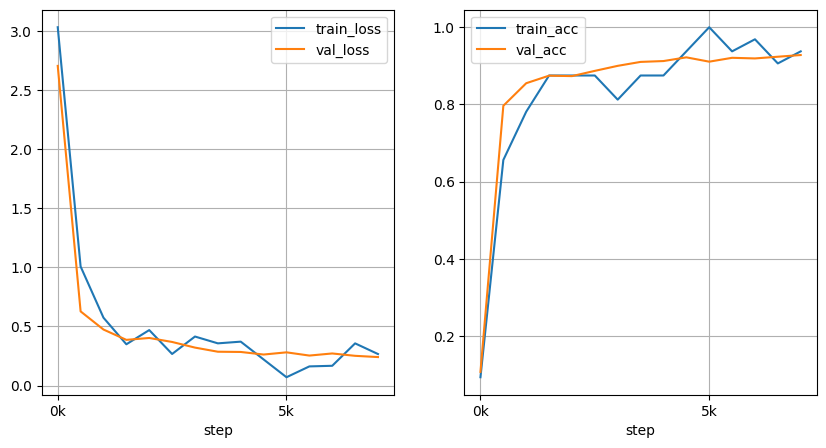

In [661]:
import pandas as pd
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=500)  #横坐标是 steps

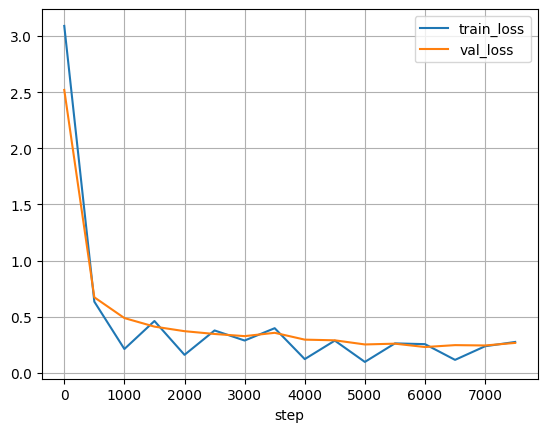

In [263]:
loss = [i["loss"] for i in record_nn_multi2["train"]]
step = [i["step"] for i in record_nn_multi2["train"]]
plt.plot(step[::500], loss[::500], label="train_loss")
# plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_nn_multi2["val"]], [i["loss"] for i in record_nn_multi2["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

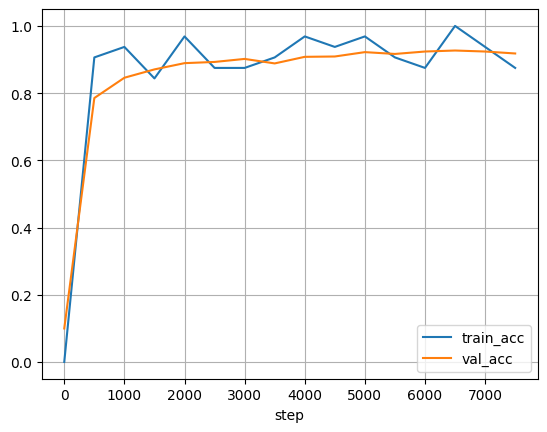

In [264]:
steps = [i["step"] for i in record_nn_multi2["train"]]
accs = [i["acc"] for i in record_nn_multi2["train"]]

# 每100步采样一次
sampled_steps = steps[::500]  # 从第0步开始，每隔100步取一个点
sampled_accs = accs[::500]

# 绘图
plt.plot(sampled_steps, sampled_accs, label="train_acc")
# plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_nn_multi2["val"]], [i["acc"] for i in record_nn_multi2["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

In [265]:
model_nn_multi2.eval()
loss, acc= evaluating6(model_nn_multi2, test_dl_multi, loss_fct_nn_multi2)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.1310
acc: 0.9595


# dropout

In [266]:
def dropout_layer(x, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return  torch.zeros_like(x)
    if dropout == 0:
        return x
    mask = (torch.rand(x.shape) > dropout).float() # rand是（0，1）的均匀分布，若误用randn是正态分布，可能会导致分布不均匀
    return mask * x / (1.0 - dropout)

In [267]:
X = torch.arange(16, dtype=torch.float32).reshape(2, 8)
print(X)
print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  6.,  0., 10.,  0., 14.],
        [ 0., 18., 20.,  0.,  0., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [268]:
class ManualMultiNetworkDropout:
    def __init__(self, layer_dims, activation='relu', dropout_layers=[], dropout=0.5):
        self.is_traning=True
        self.dropout=dropout
        self.dropout_layers=dropout_layers
        self.layer_dims = layer_dims
        self.activation = activation
        self.weights = []
        self.bias = []
        for i in range(len(layer_dims) - 1):
            # He初始化
            w = torch.tensor(np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2 / layer_dims[i]),requires_grad=True, dtype=torch.float32)
            b = torch.tensor(np.zeros((1, layer_dims[i+1])), requires_grad=True, dtype=torch.float32)
            self.weights.append(w)
            self.bias.append(b) 
          
    
    def forward(self, x):
        self.outputs = x
        for i in range(len(self.weights) - 1):
            self.outputs = torch.matmul(self.outputs, self.weights[i]) + self.bias[i]
            if self.activation == 'relu':
              self.outputs = relu(self.outputs)
            if self.is_training and i in self.dropout_layers:
              self.outputs = dropout_layer(self.outputs, self.dropout)

        self.outputs = torch.matmul(self.outputs, self.weights[-1]) + self.bias[-1]
        return  self.outputs
    
    
    def sgd(self, lr, batch_size):
        SGD(self.weights, lr, batch_size)
        SGD(self.bias, lr, batch_size)
        
    def grad_zero(self):
        for i in range(len(self.weights)):
            self.weights[i].grad.zero_()
            self.bias[i].grad.zero_()

    def eval(self):
      self.is_training=False


    def train(self):
      self.is_training=True   

In [271]:
def training_manual_dropout( model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                datas = datas.view(datas.size(0), -1)
                logits = model.forward(datas)
                loss = loss_fct(logits, labels)
                loss.backward()
                model.sgd(0.2, 32)
                model.grad_zero()
                preds = logits.argmax(-1)
            
                acc = accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                 # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating3(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [272]:
epoch = 30
layer_dims = [784, 256, 128, 64, 32, 10]
model_manual_dropout = ManualMultiNetworkDropout(layer_dims, dropout_layers=[2, 3], dropout=0.3)
early_stop_callback = EarlyStopCallback()
loss_fct_manual_dropout = nn.CrossEntropyLoss()
record_manual_dropout = training_manual_dropout(model_manual_dropout, train_dl_multi, val_dl_multi, epoch, loss_fct_manual_dropout, early_stop_callback)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 8 / global_step 14500


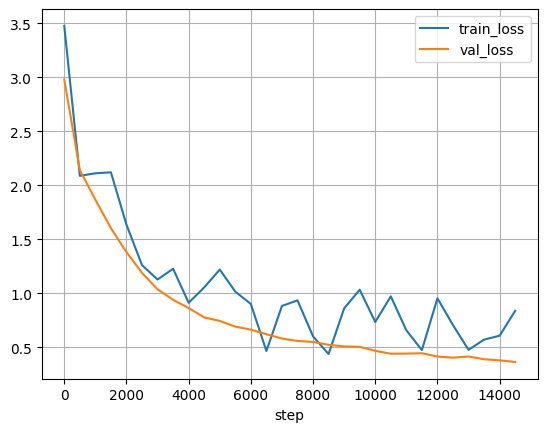

In [273]:
loss = [i["loss"] for i in record_manual_dropout["train"]]
step = [i["step"] for i in record_manual_dropout["train"]]

plt.plot(step[::500], loss[::500], label="train_loss")
# plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_manual_dropout["val"]], [i["loss"] for i in record_manual_dropout["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

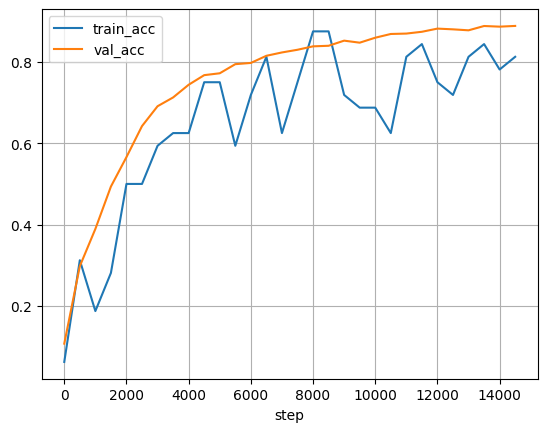

In [275]:
acc = [i["acc"] for i in record_manual_dropout["train"]]
step = [i["step"] for i in record_manual_dropout["train"]]

# 绘图
plt.plot(step[::500], acc[::500], label="train_acc")
# plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_manual_dropout["val"]], [i["acc"] for i in record_manual_dropout["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

In [276]:
model_manual_dropout.eval()
loss, acc= evaluating3(model_manual_dropout, test_dl_multi, loss_fct_manual_dropout)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.2149
acc: 0.9378


In [277]:
epoch = 30
layer_dims = [784, 256, 128, 64, 32, 10]
model = ManualMultiNetworkDropout(layer_dims, dropout_layers=[0, 1, 2, 3], dropout=0.3)
early_stop_callback = EarlyStopCallback()
loss_fct = nn.CrossEntropyLoss()
record = training_manual_dropout(model, train_dl_multi, val_dl_multi, epoch, loss_fct, early_stop_callback)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 14 / global_step 25500


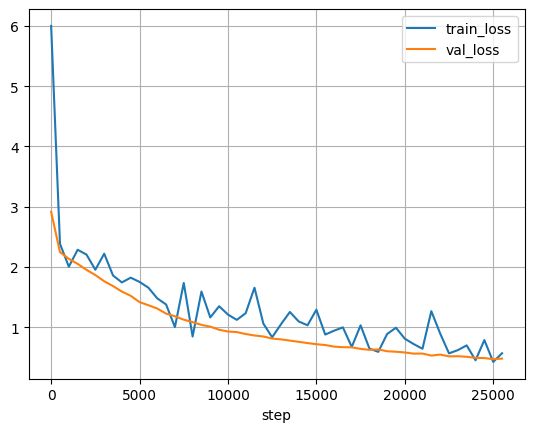

In [278]:
loss = [i["loss"] for i in record["train"]]
step = [i["step"] for i in record["train"]]

plt.plot(step[::500], loss[::500], label="train_loss")
# plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()
steps = [i["step"] for i in record["train"]]
accs = [i["acc"] for i in record["train"]]

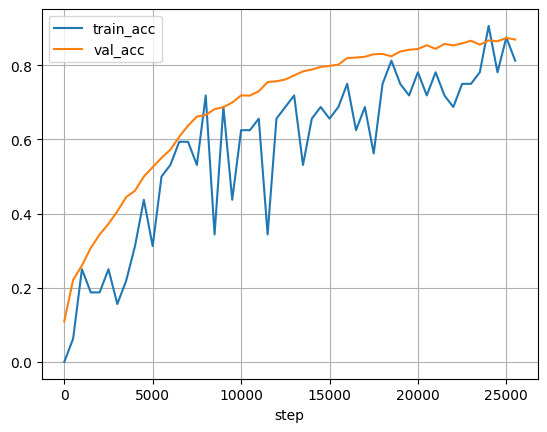

In [279]:
acc = [i["acc"] for i in record["train"]]
step = [i["step"] for i in record["train"]]

# 绘图
plt.plot(step[::500], acc[::500], label="train_acc")
# plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["acc"] for i in record["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

In [280]:
model.eval()
loss, acc= evaluating3(model, test_dl_multi, loss_fct)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.3277
acc: 0.9234


# torch.nn 实现dropout

In [283]:
class NnMultiNetworkDropout(nn.Module):
    def __init__(self, activation="relu", dropout=0.5):
        super().__init__()
        self.dropout = dropout
        # 定义可选的激活函数
        activation_fns = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "leakyrelu": nn.LeakyReLU(negative_slope=0.1),
            "gelu": nn.GELU(),
            "sigmoid": nn.Sigmoid()
        }
        assert activation in activation_fns, f"Unsupported activation: {activation}"

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            activation_fns[activation],  # 动态选择激活函数
            nn.Dropout(p=self.dropout),
            nn.Linear(256, 128),
            activation_fns[activation],  # 动态选择激活函数
            nn.Dropout(p=self.dropout),
            nn.Linear(128, 64),
            activation_fns[activation],  # 动态选择激活函数
            nn.Dropout(p=self.dropout),
            nn.Linear(64, 32),
            activation_fns[activation],  # 动态选择激活函数
            nn.Dropout(p=self.dropout),
            nn.Linear(32, 10)
        )
        self.init_weight()

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)
    


In [282]:
# 训练
def training_nn_dropout(
        model,
        train_loader,
        val_loader,
        optimizer,
        epoch,
        loss_fct,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                optimizer.zero_grad()
                logits = model(datas)
                loss = loss_fct(logits, labels)
                loss.backward()
                optimizer.step()
                preds = logits.argmax(-1)
                acc = accuracy_score(labels.detach().numpy(), preds.detach().numpy())
                record_dict["train"].append({
                    "loss": loss.detach().numpy(), "acc": acc, "step": global_step
                })

                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating6(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict



In [730]:
epoch = 30
model_nn_dropout = NnMultiNetworkDropout(dropout=0.2)
loss_fct_nn_dropout = nn.CrossEntropyLoss()
early_stop_callback = EarlyStopCallback()
# 初始化Adam优化器
optimizer_nn_dropout = torch.optim.Adam(model_nn_dropout.parameters(), lr=0.001)
record_nn_dropout = training_nn_dropout(model_nn_dropout, train_dl_multi, val_dl_multi, optimizer_nn_dropout, epoch, loss_fct_nn_dropout, early_stop_callback)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 4 / global_step 8000


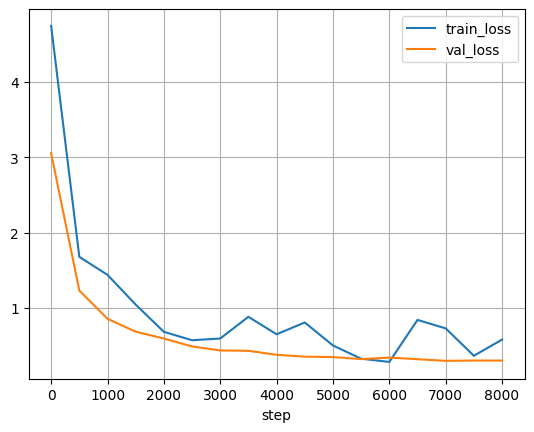

In [731]:
loss = [i["loss"] for i in record_nn_dropout["train"]]
step = [i["step"] for i in record_nn_dropout["train"]]

plt.plot(step[::500], loss[::500], label="train_loss")
# plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_nn_dropout["val"]], [i["loss"] for i in record_nn_dropout["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

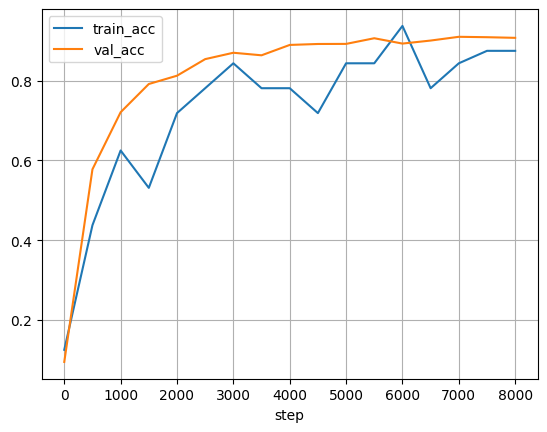

In [732]:
acc = [i["acc"] for i in record_nn_dropout["train"]]
step = [i["step"] for i in record_nn_dropout["train"]]

# 绘图
plt.plot(step[::500], acc[::500], label="train_acc")
# plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_nn_dropout["val"]], [i["acc"] for i in record_nn_dropout["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

In [736]:
model_nn_dropout.eval()
loss, acc= evaluating6(model_nn_dropout, test_dl_multi, loss_fct)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.1854
acc: 0.9473


# dropout率 0.5

In [284]:
epoch = 30
model_nn_dropout2 = NnMultiNetworkDropout(dropout=0.5)
loss_fct_nn_dropout2 = nn.CrossEntropyLoss()
early_stop_callback2 = EarlyStopCallback()
# 初始化Adam优化器
optimizer_nn_dropout2 = torch.optim.Adam(model_nn_dropout2.parameters(), lr=0.001)
record_nn_dropout2= training_nn_dropout(model_nn_dropout2, train_dl_multi, val_dl_multi, optimizer_nn_dropout2, epoch, loss_fct_nn_dropout2, early_stop_callback2)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 13 / global_step 23000


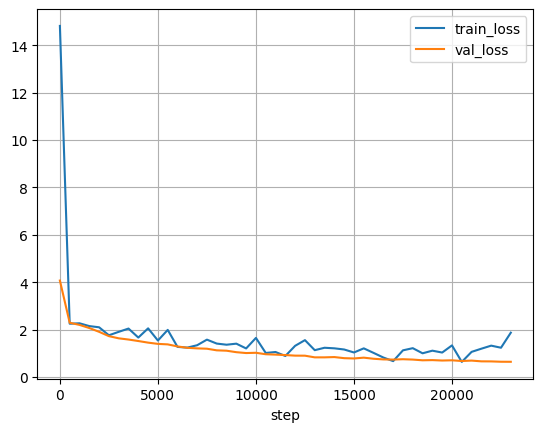

In [285]:
loss = [i["loss"] for i in record_nn_dropout2["train"]]
step = [i["step"] for i in record_nn_dropout2["train"]]

plt.plot(step[::500], loss[::500], label="train_loss")
# plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_nn_dropout2["val"]], [i["loss"] for i in record_nn_dropout2["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

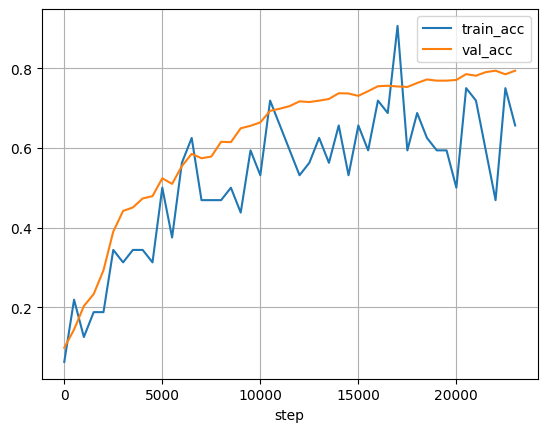

In [288]:
acc = [i["acc"] for i in record_nn_dropout2["train"]]
step = [i["step"] for i in record_nn_dropout2["train"]]

plt.plot(step[::500], acc[::500], label="train_acc")
# plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_nn_dropout2["val"]], [i["acc"] for i in record_nn_dropout2["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

In [289]:
model_nn_dropout2.eval()
loss, acc= evaluating6(model_nn_dropout2, test_dl_multi, loss_fct)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.5389
acc: 0.8314


# 多分类手动实现L2正则化

In [290]:
class ManualMultiNetworkL2:
    def __init__(self, layer_dims, activation='relu'):
        self.layer_dims = layer_dims
        self.activation = activation
        self.weights = []
        self.bias = []
        for i in range(len(layer_dims) - 1):
            # He初始化
            w = torch.tensor(np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2 / layer_dims[i]),requires_grad=True, dtype=torch.float32)
            b = torch.tensor(np.zeros((1, layer_dims[i+1])), requires_grad=True, dtype=torch.float32)
            self.weights.append(w)
            self.bias.append(b) 
          
    
    def forward(self, x):
        self.outputs = x
        for i in range(len(self.weights) - 1):
            self.outputs = torch.matmul(self.outputs, self.weights[i]) + self.bias[i]
            if self.activation == 'relu':
              self.outputs = relu(self.outputs)

        self.outputs = torch.matmul(self.outputs, self.weights[-1]) + self.bias[-1]
        return  self.outputs
    
    
    def sgd(self, lr, batch_size):
        SGD(self.weights, lr, batch_size)
        SGD(self.bias, lr, batch_size)
        
    def grad_zero(self):
        for i in range(len(self.weights)):
            self.weights[i].grad.zero_()
            self.bias[i].grad.zero_()

    def params_weights(self):
        return self.weights

In [291]:
def l2_regularization(model, lambda_=0.01):
    l2_loss = 0.0
    params = model.params_weights()
    for param in params:
        if param.requires_grad:
            l2_loss += torch.sum(param ** 2)
            
    return lambda_/2*l2_loss

In [292]:
@torch.no_grad()
def evaluating7(model, dataloader, loss_fct, lambda_):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        # 前向计算
        datas = datas.view(datas.size(0), -1)
        logits = model.forward(datas)              # 验证集预测
        loss = loss_fct(logits, labels) + l2_regularization(model, lambda_)         # 验证集损失
        loss_list.append(loss.item()) # 将验证集损失加入列表
        preds = logits.argmax(axis=-1)
        pred_list.extend(preds.detach().numpy().tolist()) # 将验证集预测结果加入列表
        label_list.extend(labels.detach().numpy().tolist())# 将验证集真实标签加入列表
        
    acc = accuracy_score(label_list, pred_list) # 计算验证集准确率
    return np.mean(loss_list), acc

In [293]:
def training_manual_l2( model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    lambda_,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                datas = datas.view(datas.size(0), -1)
                logits = model.forward(datas)
                loss = loss_fct(logits, labels) + l2_regularization(model, lambda_)
                loss.backward()
                model.sgd(0.2, 32)
                model.grad_zero()
                preds = logits.argmax(-1)
            
                acc = accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                 # evaluating
                if global_step % eval_step == 0:
                    val_loss, val_acc = evaluating7(model, val_loader, loss_fct, lambda_)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict

In [26]:
epoch = 30
lambda_ = 0.01
layer_dims = [784, 256, 128, 64, 32, 10]
model_manual_l2 = ManualMultiNetworkL2(layer_dims)
early_stop_callback = EarlyStopCallback()
loss_fct_manual_l2 = nn.CrossEntropyLoss()
record_manual_l2 = training_manual_l2(model_manual_l2, train_dl_multi, val_dl_multi, epoch, loss_fct_manual_l2, lambda_, early_stop_callback)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 7 / global_step 13500


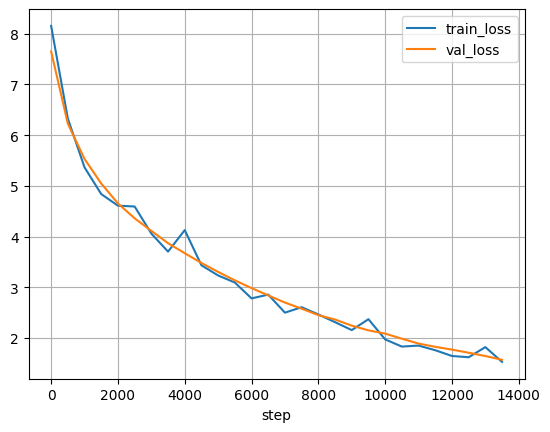

In [27]:
loss = [i["loss"] for i in record_manual_l2["train"]]
step = [i["step"] for i in record_manual_l2["train"]]

plt.plot(step[::500], loss[::500], label="train_loss")
# plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_manual_l2["val"]], [i["loss"] for i in record_manual_l2["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()


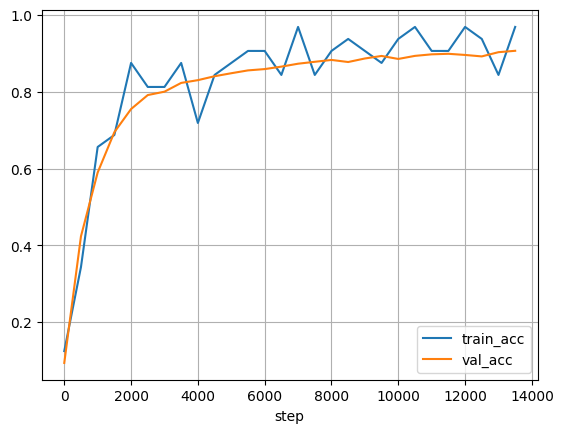

In [28]:
acc = [i["acc"] for i in record_manual_l2["train"]]
step = [i["step"] for i in record_manual_l2["train"]]
# 绘图
plt.plot(step[::500], acc[::500], label="train_acc")
# plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_manual_l2["val"]], [i["acc"] for i in record_manual_l2["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

In [30]:
loss, acc = evaluating7(model, test_dl_multi, loss_fct, lambda_)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     1.4380
acc: 0.9525


# torch.nn 实现L2正则化

In [294]:
class NnMultiNetworkL2(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()
        # 定义可选的激活函数
        activation_fns = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "leakyrelu": nn.LeakyReLU(negative_slope=0.1),
            "gelu": nn.GELU(),
            "sigmoid": nn.Sigmoid()
        }
        assert activation in activation_fns, f"Unsupported activation: {activation}"

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(256, 128),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(128, 64),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(64, 32),
            activation_fns[activation],  # 动态选择激活函数
            nn.Linear(32, 10)
        )
        self.init_weight()

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)


In [295]:
# 训练
def training_nn_l2(
        model,
        train_loader,
        val_loader,
        optimizer,
        epoch,
        loss_fct,
        early_stop_callback=None,
        eval_step=500,
):
    record_dict = {
        "train": [],
        "val": []
    }
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_loader:
                optimizer.zero_grad()
                logits = model(datas)
                loss = loss_fct(logits, labels)
                loss.backward()
                optimizer.step()
                preds = logits.argmax(-1)
                acc = accuracy_score(labels.detach().numpy(), preds.detach().numpy())
                record_dict["train"].append({
                    "loss": loss.detach().numpy(), "acc": acc, "step": global_step
                })

                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating6(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()

                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


In [34]:
epoch = 30
model_nn_l2 = NnMultiNetworkL2()
loss_fct = nn.CrossEntropyLoss()
early_stop_callback = EarlyStopCallback()
# 初始化Adam优化器
optimizer_nn_l2 = torch.optim.Adam(model_nn_l2.parameters(), lr=0.001, weight_decay=0.01)   # weight_decay 就是L2正则化中的lambda
record = training_nn_l2(model_nn_l2, train_dl_multi, val_dl_multi, optimizer_nn_l2, epoch, loss_fct, early_stop_callback)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 4 / global_step 7500


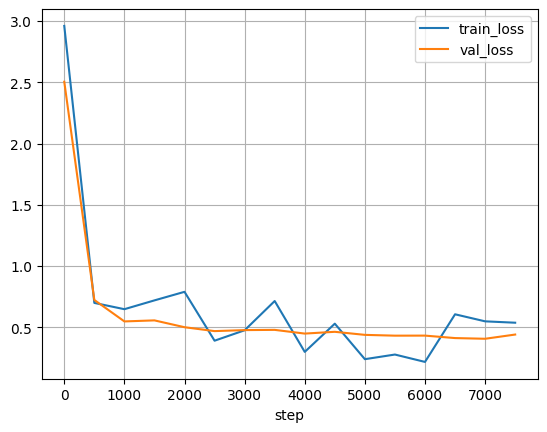

In [35]:
loss = [i["loss"] for i in record["train"]]
step = [i["step"] for i in record["train"]]

plt.plot(step[::500], loss[::500], label="train_loss")
# plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()


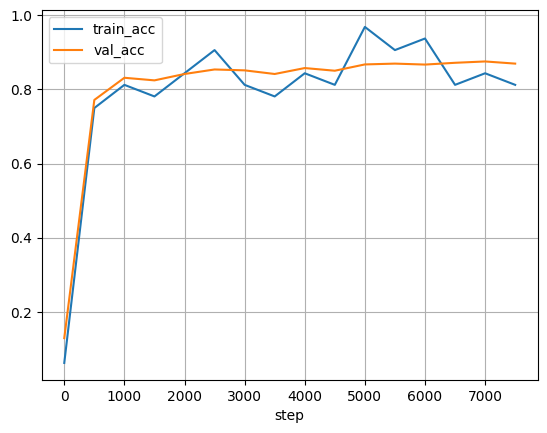

In [36]:
acc = [i["acc"] for i in record["train"]]
step = [i["step"] for i in record["train"]]
# 绘图
plt.plot(step[::500], acc[::500], label="train_acc")
# plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["acc"] for i in record["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

In [37]:
model_nn_l2.eval()
loss, acc = evaluating6(model, test_dl_multi, loss_fct)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.2512
acc: 0.9326


# L2的lambda 为0.3

In [296]:
epoch = 30
model_nn_l2_2 = NnMultiNetworkL2()
loss_fct = nn.CrossEntropyLoss()
early_stop_callback = EarlyStopCallback()
# 初始化Adam优化器
optimizer_nn_l2_2 = torch.optim.Adam(model_nn_l2_2.parameters(), lr=0.001, weight_decay=0.03)   # weight_decay 就是L2正则化中的lambda
record_nn_l2_2 = training_nn_l2(model_nn_l2_2, train_dl_multi, val_dl_multi, optimizer_nn_l2_2, epoch, loss_fct, early_stop_callback)

  0%|          | 0/51570 [00:00<?, ?it/s]

Early stop at epoch 2 / global_step 5000


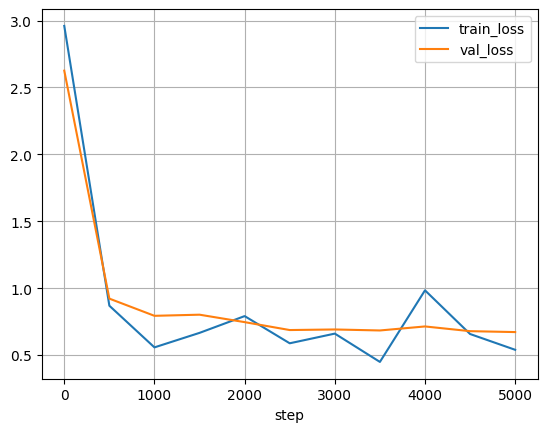

In [297]:
loss = [i["loss"] for i in record_nn_l2_2["train"]]
step = [i["step"] for i in record_nn_l2_2["train"]]

plt.plot(step[::500], loss[::500], label="train_loss")
# plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_nn_l2_2["val"]], [i["loss"] for i in record_nn_l2_2["val"]], label="val_loss")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()


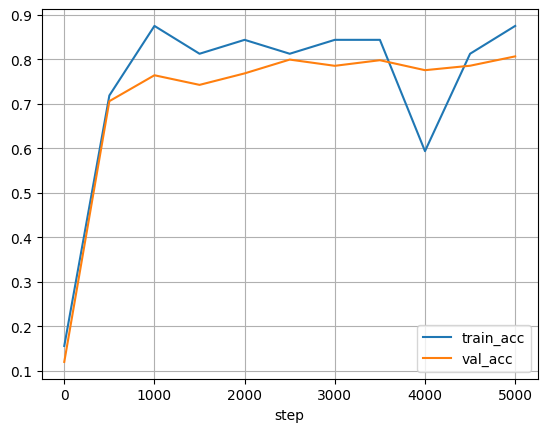

In [298]:
acc = [i["acc"] for i in record_nn_l2_2["train"]]
step = [i["step"] for i in record_nn_l2_2["train"]]
# 绘图
plt.plot(step[::500], acc[::500], label="train_acc")
# plt.plot([i["step"] for i in record["train"]], [i["acc"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record_nn_l2_2["val"]], [i["acc"] for i in record_nn_l2_2["val"]], label="val_acc")
plt.grid()
plt.legend()
plt.xlabel("step")
plt.show()

In [299]:
model_nn_l2_2.eval()
loss, acc = evaluating6(model_nn_l2_2, test_dl_multi, loss_fct)
print(f"loss:     {loss:.4f}\nacc: {acc:.4f}")

loss:     0.4745
acc: 0.8839


# 10折交叉验证

# 回归

In [142]:
# 设置随机种子保证可复现性
np.random.seed(42)
torch.manual_seed(42)

# 参数配置
n_samples = 10000       # 总样本量
p = 500                 # 特征维度
train_size = 7000       # 训练集大小
test_size = 3000        # 测试集大小
true_bias = 0.028       # 真实偏置项
true_weights = 0.0056   # 统一权重系数（所有特征同等重要）

# 生成数据
def generate_data(n_samples, p):
    # 生成特征矩阵 (n_samples, p)
    X = np.random.randn(n_samples, p)
    
    # 生成真实权重 (p, 1) - 所有特征权重相同
    w = np.full((p, 1), true_weights)
    
    # 生成噪声项 ϵ ~ N(0, 0.1)
    epsilon = np.random.normal(0, 0.2, size=(n_samples, 1))
    
    X = (X - X.mean(axis=0)) / X.std(axis=0)  # 先标准化
    
    # 计算标签 y = 0.028 + 0.0056*∑x_i + ϵ
    y = true_bias + X.dot(w) + epsilon
    
    
    return X, y.squeeze()  # 将y从(n_samples,1)压缩为(n_samples,)

# 生成完整数据集
X, y = generate_data(n_samples, p)

# 数据标准化（重要！高维数据必须标准化）
# 不同特征的量纲和取值范围差异大（如年龄 0-100，收入 0-1,000,000），导致：
#     权重大的特征可能仅仅因为数值大而主导模型。
#     梯度下降收敛缓慢（需反复调整学习率）。
# 假设有两个特征：
#     x1: 年龄（范围 0-100）
#     x2: 收入（范围 0-1,000,000）
# 若直接计算点积 y=w1*x1+w2*x2：
#     收入 x2的微小变化会完全掩盖年龄 x1的影响。
#     梯度下降时，w2的更新步长需要极小的学习率，而 w1则需要较大的学习率，难以平衡。
# X = (X - X.mean(axis=0)) / X.std(axis=0)

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, random_state=42
)

# 转换为PyTorch张量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 验证生成数据的正确性
def verify_data(X, y, n_check=3):
    for i in range(n_check):
        manual_y = true_bias + 0.0056 * X[i].sum()
        print(f"样本{i}: 计算值={manual_y:.4f}, 生成值={y[i]:.4f}, 差值={abs(manual_y - y[i]):.4f}")

print("=== 训练集验证 ===")
verify_data(X_train, y_train)
print("\n=== 测试集验证 ===")
verify_data(X_test, y_test)

# 输出数据形状
print("\n=== 数据形状 ===")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# 检查权重一致性
print(f"\n真实权重: 偏置={true_bias}, 特征权重={true_weights} (所有特征相同)")

=== 训练集验证 ===
样本0: 计算值=0.1533, 生成值=0.3005, 差值=0.1473
样本1: 计算值=0.0437, 生成值=-0.0745, 差值=0.1181
样本2: 计算值=-0.1449, 生成值=0.0553, 差值=0.2003

=== 测试集验证 ===
样本0: 计算值=0.0827, 生成值=-0.0233, 差值=0.1059
样本1: 计算值=0.0195, 生成值=0.2838, 差值=0.2643
样本2: 计算值=0.0179, 生成值=-0.1031, 差值=0.1210

=== 数据形状 ===
X_train: torch.Size([7000, 500]), y_train: torch.Size([7000])
X_test: torch.Size([3000, 500]), y_test: torch.Size([3000])

真实权重: 偏置=0.028, 特征权重=0.0056 (所有特征相同)


In [65]:
seed = 17
train_ds_nn_logits = TensorDataset(X_train, y_train)
test_ds_nn_logits = TensorDataset(X_test, y_test)

In [86]:
def k_fold_cv_logis(dataset, n_splits=10, epochs=30, batch_size=32, lr=0.001):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold + 1}/{n_splits}")
        # 数据划分
        train_subsampler = Subset(dataset, train_idx)
        val_subsampler = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size)
        
        model_nn_logis_k_fold = NnNeuralNetwork()
        loss_fct_nn_logis_k_fold = nn.MSELoss()
        early_stop_callback_nn_logis_k_fold = EarlyStopCallback()
        # 初始化Adam优化器
        optimizer_nn_logis_k_fold = torch.optim.Adam(model_nn_logis_k_fold.parameters(), lr=lr, weight_decay=1e-4)
        start_time=time()
        record_nn_logis_k_fold  = training_nn_logist(model_nn_logis_k_fold, train_loader, val_loader, optimizer_nn_logis_k_fold, epochs, loss_fct_nn_logis_k_fold, early_stop_callback_nn_logis_k_fold)
        train_time=time()-start_time
        model_nn_logis_k_fold.eval()
        val_loss, val_mae = evaluating4(model_nn_logis_k_fold, val_loader, loss_fct_nn_logis_k_fold)
        # 记录表格的数据
        results.append({
        "Fold": fold + 1,
        "Train Size": len(train_idx),
        "Val Size": len(val_idx),
        "Val Mae": np.round(float(val_mae), 4),
        "Val Loss": np.round(val_loss, 4),
        "Time (s)": np.round(train_time, 1),
         }) 
        
    # 转换为表格并计算均值/标准差
    df = pd.DataFrame(results)
    mean_row = {
        "Fold": "Mean",
        "Train Size": "-",
        "Val Size": "-",
        "Val Mae": f"{df['Val Mae'].mean():.4f} ± {df['Val Mae'].std():.4f}",
        "Val Loss": f"{df['Val Loss'].mean():.4f} ± {df['Val Loss'].std():.4f}",
        "Time (s)": f"{df['Time (s)'].mean():.1f}",
    }
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)
    
    # 打印表格
    print(df.to_markdown(index=False, tablefmt="github"))

In [87]:
k_fold_cv_logis(train_ds_nn_logits)


Fold 1/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 4 / global_step 800

Fold 2/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 1000

Fold 3/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 700

Fold 4/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 700

Fold 5/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 700

Fold 6/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 4 / global_step 800

Fold 7/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 4 / global_step 900

Fold 8/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 4 / global_step 900

Fold 9/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 700

Fold 10/10


  0%|          | 0/5910 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 700
| Fold   | Train Size   | Val Size   | Val Mae         | Val Loss        |   Time (s) |
|--------|--------------|------------|-----------------|-----------------|------------|
| 1      | 6300         | 700        | 0.2627          | 0.0945          |        6.7 |
| 2      | 6300         | 700        | 0.2599          | 0.0925          |        5.5 |
| 3      | 6300         | 700        | 0.2509          | 0.0836          |        2.7 |
| 4      | 6300         | 700        | 0.2628          | 0.0964          |        2.6 |
| 5      | 6300         | 700        | 0.2489          | 0.0816          |        2.7 |
| 6      | 6300         | 700        | 0.2544          | 0.0862          |        3.1 |
| 7      | 6300         | 700        | 0.2607          | 0.0957          |        3.5 |
| 8      | 6300         | 700        | 0.2796          | 0.1079          |        3.7 |
| 9      | 6300         | 700        | 0.2733          | 0.1016          |      

# 二分类

In [146]:
# 设置随机种子保证可复现性
np.random.seed(42)

# 参数配置
n_samples = 10000  # 每个数据集的样本量
p = 200  # 特征维度
train_size = 7000  # 训练集大小
test_size = 3000  # 测试集大小
mean_diff = 1.0  # 两个数据集均值的差异幅度
common_var = 1.0  # 共同的方差

# 生成第一个数据集（标签0）
X0 = np.random.normal(loc=-mean_diff / 2, scale=np.sqrt(common_var), size=(n_samples, p))
y0 = np.zeros(n_samples)  # 标签全为0

# 生成第二个数据集（标签1）
X1 = np.random.normal(loc=mean_diff / 2, scale=np.sqrt(common_var), size=(n_samples, p))
y1 = np.ones(n_samples)  # 标签全为1

# 合并两个数据集
X = np.vstack((X0, X1))
y = np.hstack((y0, y1))
print(X.shape)
# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size * 2, test_size=test_size * 2, random_state=42, stratify=y
)

# 将np转为tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)
train_ds_binary = TensorDataset(X_train, y_train)
test_ds_binary = TensorDataset(X_test, y_test)

(20000, 200)


In [151]:
def k_fold_cv_binary(dataset, n_splits=10, epochs=30, batch_size=32, lr=0.001):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold + 1}/{n_splits}")
        # 数据划分
        train_subsampler = Subset(dataset, train_idx)
        val_subsampler = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size)

        model_nn_binary_k_fold = NnBinaryNetwork()
        loss_fct_nn_binary_k_fold  = nn.BCEWithLogitsLoss()
        early_stop_callback_nn_binary_k_fold  = EarlyStopCallback()
        # 初始化Adam优化器
        optimizer_nn_binary_k_fold = torch.optim.Adam(model_nn_binary_k_fold.parameters(), lr=lr, weight_decay=1e-4)
        start_time=time()
        record_nn_binary = training_nn_binary(model_nn_binary_k_fold, train_loader, val_loader, optimizer_nn_binary_k_fold, epochs, loss_fct_nn_binary_k_fold, early_stop_callback_nn_binary_k_fold)
        train_time=time()-start_time
        
        model_nn_binary_k_fold.eval()
        val_loss, val_acc=evaluating5(model_nn_binary_k_fold, val_loader, loss_fct_nn_binary_k_fold)
        # 记录表格的数据
        results.append({
        "Fold": fold + 1,
        "Train Size": len(train_idx),
        "Val Size": len(val_idx),
        "Val Accuracy": np.round(val_acc, 4),
        "Val Loss": np.round(val_loss, 4),
        "Time (s)": np.round(train_time, 1),
         }) 
        
    # 转换为表格并计算均值/标准差
    df = pd.DataFrame(results)
    mean_row = {
        "Fold": "Mean",
        "Train Size": "-",
        "Val Size": "-",
        "Val Accuracy": f"{df['Val Accuracy'].mean():.4f} ± {df['Val Accuracy'].std():.4f}",
        "Val Loss": f"{df['Val Loss'].mean():.4f} ± {df['Val Loss'].std():.4f}",
        "Time (s)": f"{df['Time (s)'].mean():.1f}",
    }
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)
    
    # 打印表格
    print(df.to_markdown(index=False, tablefmt="github"))

In [152]:
k_fold_cv_binary(dataset=train_ds_binary)


Fold 1/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200

Fold 2/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200

Fold 3/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200

Fold 4/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200

Fold 5/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200

Fold 6/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200

Fold 7/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200

Fold 8/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200

Fold 9/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200

Fold 10/10


  0%|          | 0/11820 [00:00<?, ?it/s]

Early stop at epoch 3 / global_step 1200
| Fold   | Train Size   | Val Size   | Val Accuracy    | Val Loss        |   Time (s) |
|--------|--------------|------------|-----------------|-----------------|------------|
| 1      | 12600        | 1400       | 1.0             | 0.0             |        7.8 |
| 2      | 12600        | 1400       | 1.0             | 0.0             |        5.5 |
| 3      | 12600        | 1400       | 1.0             | 0.0             |        5.6 |
| 4      | 12600        | 1400       | 1.0             | 0.0             |        5.4 |
| 5      | 12600        | 1400       | 1.0             | 0.0             |        5.4 |
| 6      | 12600        | 1400       | 1.0             | 0.0             |        5.4 |
| 7      | 12600        | 1400       | 1.0             | 0.0             |        5.5 |
| 8      | 12600        | 1400       | 1.0             | 0.0             |        5.6 |
| 9      | 12600        | 1400       | 1.0             | 0.0             |     

# 多分类

In [88]:
train_transform = transforms.Compose([
    transforms.RandomRotation(5),                      # 减小旋转角度
    transforms.RandomAffine(0, translate=(0.05, 0.05)),  # 减小平移范围
    transforms.RandomCrop(28, padding=4, padding_mode='edge'),  # 安全裁剪
    transforms.ColorJitter(brightness=0.05, contrast=0.05),  # 降低调整强度
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.005),  # 提前加噪声
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # 在Tensor上操作
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])
train_ds_multi_k = torchvision.datasets.MNIST("./Datasets/MNIST", train=True, transform=train_transform, download=True)
test_ds_multi_k = torchvision.datasets.MNIST("./Datasets/MNIST", train=False, transform=test_transform, download=True)

In [89]:
train_ds_multi_k[0][1]

5

In [91]:
def k_fold_cv_multi(dataset, n_splits=10, epochs=30, batch_size=32, lr=0.001):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold + 1}/{n_splits}")
        # 数据划分
        train_subsampler = Subset(dataset, train_idx)
        val_subsampler = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size)
        
        model_nn_dropout_k_fold = NnMultiNetworkDropout(dropout=0.2)
        loss_fct_nn_dropout_k_fold = nn.CrossEntropyLoss()
        early_stop_callback_nn_dropout_k_fold = EarlyStopCallback()
        # 初始化Adam优化器
        optimizer_nn_dropout_k_fold = torch.optim.Adam(model_nn_dropout_k_fold.parameters(), lr=lr)
        start_time=time()
        record_nn_dropout = training_nn_dropout(model_nn_dropout_k_fold, train_loader, val_loader, optimizer_nn_dropout_k_fold, epochs, loss_fct_nn_dropout_k_fold, early_stop_callback_nn_dropout_k_fold)
        train_time=time()-start_time
        
        model_nn_dropout_k_fold.eval()
        val_loss, val_acc=evaluating6(model_nn_dropout_k_fold, val_loader, loss_fct_nn_dropout_k_fold)
        # 记录表格的数据
        results.append({
        "Fold": fold + 1,
        "Train Size": len(train_idx),
        "Val Size": len(val_idx),
        "Val Accuracy": np.round(val_acc, 4),
        "Val Loss": np.round(val_loss, 4),
        "Time (s)": np.round(train_time, 1),
         }) 
        
    # 转换为表格并计算均值/标准差
    df = pd.DataFrame(results)
    mean_row = {
        "Fold": "Mean",
        "Train Size": "-",
        "Val Size": "-",
        "Val Accuracy": f"{df['Val Accuracy'].mean():.4f} ± {df['Val Accuracy'].std():.4f}",
        "Val Loss": f"{df['Val Loss'].mean():.4f} ± {df['Val Loss'].std():.4f}",
        "Time (s)": f"{df['Time (s)'].mean():.1f}",
    }
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)
    
    # 打印表格
    print(df.to_markdown(index=False, tablefmt="github"))

In [92]:
k_fold_cv_multi(dataset=train_ds_multi_k)


Fold 1/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 9000

Fold 2/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 9500

Fold 3/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 9500

Fold 4/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 8500

Fold 5/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 9000

Fold 6/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 6 / global_step 10500

Fold 7/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 9500

Fold 8/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 9500

Fold 9/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 6 / global_step 10500

Fold 10/10


  0%|          | 0/50640 [00:00<?, ?it/s]

Early stop at epoch 5 / global_step 9000
| Fold   | Train Size   | Val Size   | Val Accuracy    | Val Loss        |   Time (s) |
|--------|--------------|------------|-----------------|-----------------|------------|
| 1      | 54000        | 6000       | 0.9225          | 0.2748          |      372.4 |
| 2      | 54000        | 6000       | 0.9197          | 0.274           |      387.3 |
| 3      | 54000        | 6000       | 0.9147          | 0.293           |      387.3 |
| 4      | 54000        | 6000       | 0.9122          | 0.2968          |      348.1 |
| 5      | 54000        | 6000       | 0.9085          | 0.3001          |      364.5 |
| 6      | 54000        | 6000       | 0.9192          | 0.2648          |      427.8 |
| 7      | 54000        | 6000       | 0.9182          | 0.2724          |      385.3 |
| 8      | 54000        | 6000       | 0.9207          | 0.2764          |      384.9 |
| 9      | 54000        | 6000       | 0.9138          | 0.2952          |     

NameError: name 'df' is not defined